## Environment setup

In [1]:
import random
from typing import Annotated
from pydantic import Field
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display
from langchain_core.messages import HumanMessage

## Tool definition

In [2]:
@tool("get_customer_info_tool", parse_docstring=True)
def get_customer_info(
    customerid: Annotated[
        str, Field(description="CustomerID to retrieve information for.")
    ],
) -> dict:
    """
    Get customer iformation from internal database.

    Args:
        customerid (str): CustomerID to retrieve information for.

    Returns:
        dict: A dictionary containing information about a customer.
    """
    try:
        customer_info = {
            "customerid": 123456789,
            "customer_name": "Martina Chlebcova",
            "customer_address": "Dubova ulica 33A, Samorin, 931 01",
            "customer_policy": "CASCO"
            }

        return customer_info

    except Exception as e:
        print(f"Error retrieving customer information: {e}")
        return {"error": str(e)}

In [3]:
# get_customer_info("123456789")

In [4]:
@tool("load_image_tool", parse_docstring=True)
def load_image(image_path: str) -> dict:
    """
    Load an image from disk and return the PIL image object and the original path.
    
    Args:
        image_path (str): Path to the image file.

    Returns:
        dict: A dictionary containing the loaded PIL image object under 'image' key
              and the original image path under 'image_path' key.
    """
    print(f"Loading image from {image_path}")
    image = Image.open(image_path)
    return {"image": image, "image_path": image_path}

In [5]:
# load_image("damaged_car.png")

In [6]:
@tool("detect_damage_tool", parse_docstring=True)
def detect_damage(image: str) -> dict:
    """
    Detect and return a list of damaged car parts from the image. (Mock implementation).

    Args:
        image (str): Image file.

    Returns:
        dict: A dictionary containing the list of damaged parts.
    """
    parts = [
        "front bumper", "rear bumper", "left headlight", "hood", "windshield",
        "left door", "right door", "trunk"
    ]
    detected_parts = random.sample(parts, k=random.randint(1, 4))
    print(f"Detected damaged parts: {detected_parts}")
    return {"damaged_parts": detected_parts}

In [7]:
# detect_damage("")

In [8]:
@tool("classify_damage_tool", parse_docstring=True)
def classify_damage(damaged_parts: list[str]) -> dict:
    """
    Assign a severity level (minor, moderate, severe) to each damaged part.

    Args:
        damaged_parts (list[str)): List of damaged parts.

    Returns:
        dict: A dictionary containing damage classification level.
    """
    severity = {}
    for part in damaged_parts:
        severity[part] = random.choice(["minor", "moderate", "severe"])
    print(f"Damage severity: {severity}")
    return {"damage_severity": severity}

In [9]:
# classify_damage({"damaged_parts": ["front bumper", "left door", "hood", "trunk"]})

In [10]:
@tool("estimate_damage_cost_tool", parse_docstring=True)
def estimate_damage_cost(damage_severity: dict[str, str]) -> dict:
    """
    Estimate total damage repair cost based on the severity of each damaged part.
    
    Args:
        damage_severity (dict[str, str]): Dictionary with level of severity
        for damaged parts.

    Returns:
        dict: A dictionary containing estimate of costs for damaged parts.
    """
    severity_cost_map = {
        "minor": 200,
        "moderate": 750,
        "severe": 1500
    }
    total_cost = 0
    part_costs = {}
    for part, severity in damage_severity.items():
        cost = severity_cost_map[severity]
        part_costs[part] = cost
        total_cost += cost

    print(f"Estimated cost: ${total_cost}")
    return {
        "estimated_cost": total_cost,
        "cost_breakdown": part_costs
    }

In [11]:
# estimate_damage_cost({'damage_severity': {'front bumper': 'severe',
#   'left door': 'moderate',
#   'hood': 'severe',
#   'trunk': 'minor'}})

In [12]:
@tool("summarize_output_tool", parse_docstring=True)
def summarize_output(cost_breakdown: dict[str, int], estimated_cost: int) -> dict:
    """
    Generate and print a readable summary of damage and estimated repair costs.

    Args:
        cost_breakdown (dict[str, int]): Breakdown of costs for damaged parts.
        estimated_cost (int): Estimated cost to repair the damaged parts.

    Returns:
        dict: A dictionary containing the summary of the damage assessment.
    """
    print("\n📄 --- Damage Report ---")
    for part, cost in cost_breakdown.items():
        print(f"{part}: ${cost}")
    print(f"Total Estimated Cost: ${estimated_cost}")
    return {
        "summary": "Damage assessment complete.",
        "total_cost": estimated_cost
    }

In [13]:
# summarize_output({'estimated_cost': 3950,
#  'cost_breakdown': {'front bumper': 1500,
#   'left door': 750,
#   'hood': 1500,
#   'trunk': 200}})

In [14]:
@tool("locate_car_repair_shop_tool", parse_docstring=True)
def locate_car_repair_shop(
    location: Annotated[
        str, Field(description="Location for nearest car repair shop for.")
    ], 
) -> dict:
    """
    Get nearest car repair shop.

    Args:
        location (str): Location for nearest car repair shop for.

    Returns:
        dict: A dictionary containing information about the location for nearest car repair shop.
    """
    try:
        alternatives = [
            "FRANCE-TECH Nitra s.r.o., Hlohovecká 9, 94901 Nitra",
            "ALBEX Plus s.r.o, Novozámocká 2796/3A, 94901 Nitra",
            "AUTOSLUŽBY NITRA , s.r.o., Dlhá 124, 94907 Nitra - Janíkovce",
            "CARS SERVICE, s.r.o., Rastislavova 2, 95141 Nitra - Lužianky",
            "N - motor, s.r.o., Drážovská cesta 5, 94901 Nitra"
        ]
        nearest_shop = random.sample(alternatives, k=random.randint(1, 5))
        print(f"Nearest car repair shops: {nearest_shop}")
        return {"nearest_shops": nearest_shop}

    except Exception as e:
        print(f"Error retrieving customer information: {e}")
        return {"error": str(e)}

In [15]:
# locate_car_repair_shop.invoke({"location": "Nitra"})

## LLM setup

In [16]:
MODEL_NAME = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"
MODEL_PROVIDER = "bedrock_converse"

llm = init_chat_model(MODEL_NAME, model_provider=MODEL_PROVIDER, temperature=0)

tools = [get_customer_info,
         load_image,
         detect_damage,
         classify_damage,
         estimate_damage_cost,
         summarize_output,
         locate_car_repair_shop]
llm_with_tools = llm.bind_tools(tools)

In [17]:
SYSTEM_PROMPT = (
    "You are an AI assistant specialized in handling car accident claims for clients insured with ČSOB. "
    "Your tasks are to:\n"
    "- Provide the client with information about the nearest car repair shops based on their location.\n"
    "- Offer an approximate estimate of the damage to the client’s car in understandable terms.\n"
    "- Inform the client clearly whether the damage described is covered by their ČSOB insurance policy, "
    "referencing relevant coverage such as CASCO or liability insurance.\n"
    "- Explain insurance terms simply, including any conditions or limitations that might apply.\n"
    "- Maintain a professional, empathetic, and helpful tone throughout the interaction, guiding the client step-by-step through the claims process."
)

## Graph builder

In [18]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def claim_handling_agent(state: State):
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

In [19]:
graph_builder = StateGraph(State)

graph_builder.add_node("claim_handling_agent", claim_handling_agent)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "claim_handling_agent")
graph_builder.add_conditional_edges("claim_handling_agent", tools_condition)
graph_builder.add_edge("tools", "claim_handling_agent")


memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

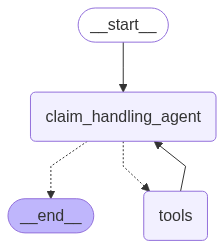

In [20]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Talking to AI agent

In [23]:
config = {"configurable": {"thread_id": "1"}}

# user_input = """
# Hi, my name is Martina. I've just had a car accident. 
# What should I do? Can you help me?
# """
# user_input = """My customerid is 123456789"""
user_input = """Yes, the photo is here (damaged_car.png). I'm currently located in Nitra."""

for event in graph.stream(
    {"messages": [HumanMessage(user_input)]}, config=config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, the photo is here (damaged_car.png). I'm currently located in Nitra.
================================== Ai Message ==================================

[{'type': 'text', 'text': "I'll help you analyze the damage from the photo and find a repair shop in Nitra.\n\nFirst, let me analyze the damage from your photo:"}, {'type': 'tool_use', 'name': 'load_image_tool', 'input': {'image_path': 'damaged_car.png'}, 'id': 'tooluse_R4oJLYnrRmO1MDl83hkFwQ'}]
Tool Calls:
  load_image_tool (tooluse_R4oJLYnrRmO1MDl83hkFwQ)
 Call ID: tooluse_R4oJLYnrRmO1MDl83hkFwQ
  Args:
    image_path: damaged_car.png
Loading image from damaged_car.png
================================= Tool Message =================================
Name: load_image_tool

Error: AttributeError("type object 'Image' has no attribute 'open'")
 Please fix your mistakes.
================================== Ai Message ==================================

[{'t